# Import required libraries 

In [4]:
import os
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Constants

In [5]:
NUM_CLASSES = 45
RANDOM_SEED = 45
BATCH_SIZE = 32
EPOCHS = 100
MODEL_PATH = "sign_language_model.h5"

In [6]:
class SignLanguageClassifier:
    def __init__(self):
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(
            static_image_mode=True,
            max_num_hands=2,
            min_detection_confidence=0.5
        )
        self.model = self._build_model()
        
    def _build_model(self):
        """Create neural network architecture"""
        model = Sequential([
            Dense(256, activation='relu', input_shape=(126,)),
            Dropout(0.3),
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(NUM_CLASSES, activation='softmax')
        ])
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

    def process_image(self, image_path):
        """Extract hand landmarks from image"""
        image = cv2.imread(image_path)
        if image is None:
            return None
            
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.hands.process(image_rgb)
        
        if not results.multi_hand_landmarks:
            return None
            
        landmarks = []
        landmarks.extend(self._extract_landmarks(results.multi_hand_landmarks[0]))
        
        if len(results.multi_hand_landmarks) > 1:
            landmarks.extend(self._extract_landmarks(results.multi_hand_landmarks[1]))
        else:
            landmarks.extend([0.0] * 63) # Pad for second hand
            
        return np.array(landmarks)

    def _extract_landmarks(self, hand_landmarks):
        """Extract x,y,z coordinates from landmarks"""
        return [coord for landmark in hand_landmarks.landmark 
                for coord in (landmark.x, landmark.y, landmark.z)]

    def load_dataset(self, base_dir):
        """Load and preprocess full dataset"""
        X, y = [], []
        
        for split in ['train', 'test', 'valid']:
            image_dir = os.path.join(base_dir, split, 'images')
            label_dir = os.path.join(base_dir, split, 'labels')
            
            if not (os.path.exists(image_dir) and os.path.exists(label_dir)):
                continue
                
            print(f"Processing {split} directory...")
            
            for label_file in os.listdir(label_dir):
                image_name = label_file.replace('.txt', '.jpg')
                image_path = os.path.join(image_dir, image_name)
                label_path = os.path.join(label_dir, label_file)
                
                landmarks = self.process_image(image_path)
                if landmarks is None:
                    continue
                    
                with open(label_path, 'r') as f:
                    label = int(f.readline().strip().split()[0])
                    
                X.append(landmarks)
                y.append(label)
        
        return np.array(X), to_categorical(y, NUM_CLASSES)

    def train(self, X, y, validation_split=0.2):
        """Train the model"""
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=validation_split,
            random_state=RANDOM_SEED,
        )
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE
        )
        
        self.plot_training_history(history)
        self.evaluate(X_test, y_test)
        self.model.save(MODEL_PATH)
        
    def plot_training_history(self, history):
        """Plot accuracy and loss curves"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        ax1.plot(history.history['accuracy'], label='Training')
        ax1.plot(history.history['val_accuracy'], label='Validation')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        
        ax2.plot(history.history['loss'], label='Training')
        ax2.plot(history.history['val_loss'], label='Validation')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
    def evaluate(self, X_test, y_test):
        """Evaluate model performance"""
        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f"\nTest Accuracy: {accuracy*100:.2f}%")
        print(f"Test Loss: {loss:.4f}")

# Usage

Processing train directory...
Processing test directory...
Processing valid directory...
Epoch 1/100
51/51 [==============================] - 1s 6ms/step - loss: 3.6065 - accuracy: 0.0743 - val_loss: 3.2939 - val_accuracy: 0.1496
Epoch 2/100
51/51 [==============================] - 0s 3ms/step - loss: 3.1188 - accuracy: 0.1642 - val_loss: 2.8001 - val_accuracy: 0.3791
Epoch 3/100
51/51 [==============================] - 0s 3ms/step - loss: 2.7172 - accuracy: 0.2815 - val_loss: 2.3089 - val_accuracy: 0.5362
Epoch 4/100
51/51 [==============================] - 0s 3ms/step - loss: 2.2246 - accuracy: 0.4064 - val_loss: 1.8040 - val_accuracy: 0.6608
Epoch 5/100
51/51 [==============================] - 0s 3ms/step - loss: 1.8687 - accuracy: 0.5000 - val_loss: 1.4804 - val_accuracy: 0.6858
Epoch 6/100
51/51 [==============================] - 0s 3ms/step - loss: 1.5480 - accuracy: 0.5743 - val_loss: 1.1997 - val_accuracy: 0.7781
Epoch 7/100
51/51 [==============================] - 0s 3ms/step 

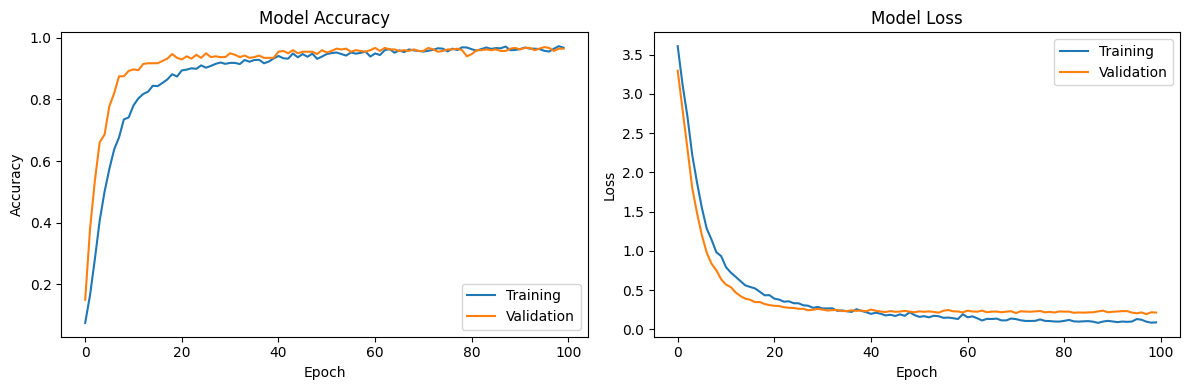

13/13 [==============================] - 0s 2ms/step - loss: 0.2137 - accuracy: 0.9651

Test Accuracy: 96.51%
Test Loss: 0.2137


In [7]:
if __name__ == "__main__":
    classifier = SignLanguageClassifier()
    X, y = classifier.load_dataset(".")
    classifier.train(X, y)

'Class: 1'

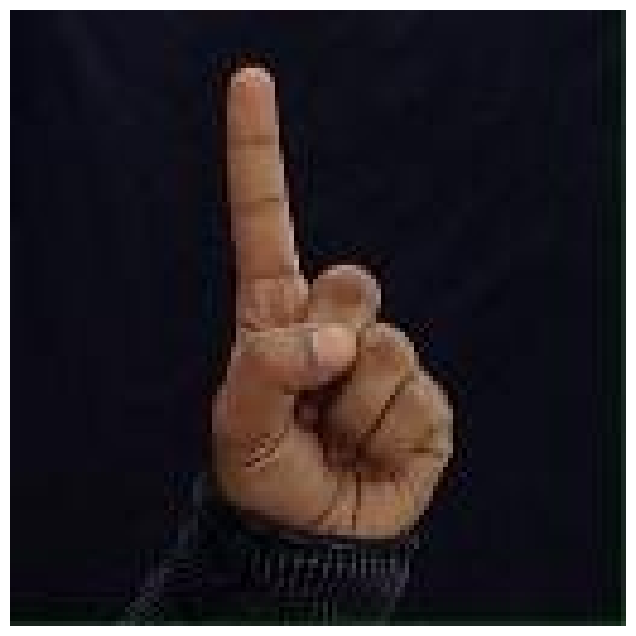

'Class: 2'

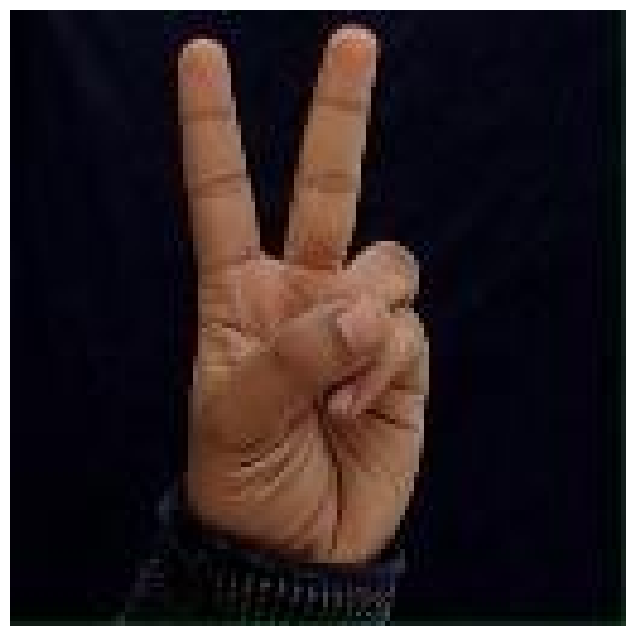

'Class: 3'

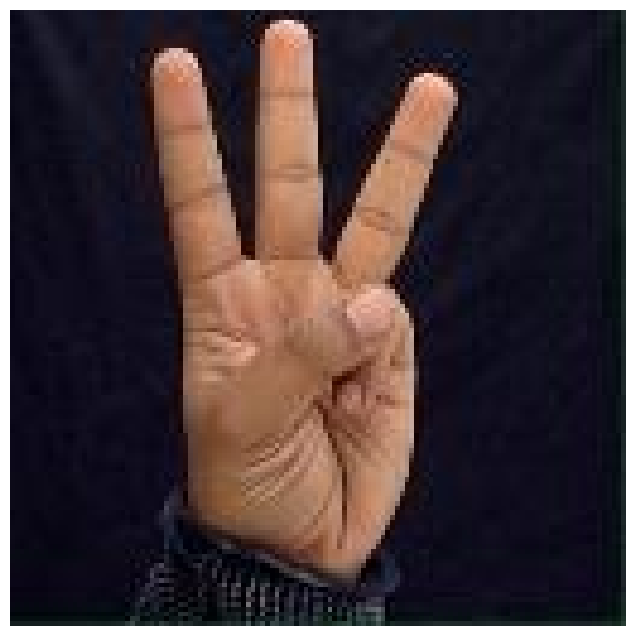

'Class: 4'

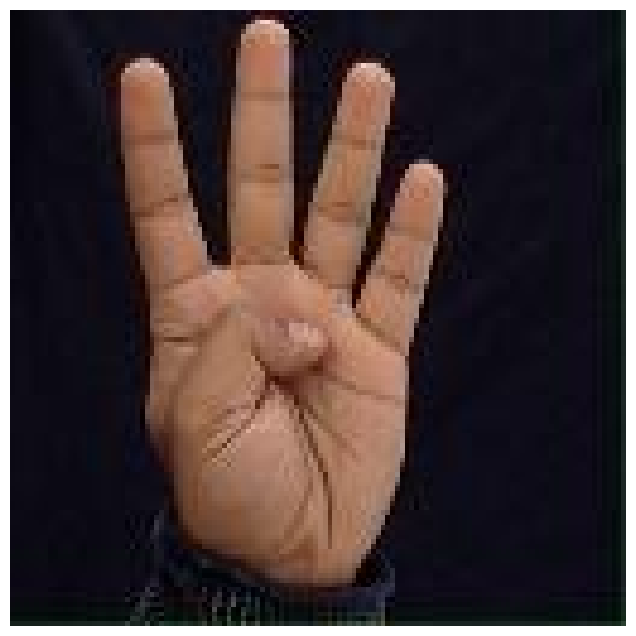

'Class: 5'

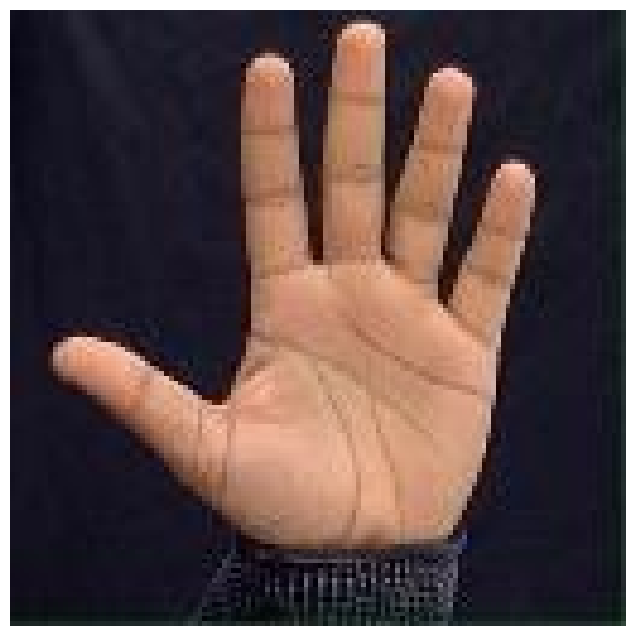

'Class: 6'

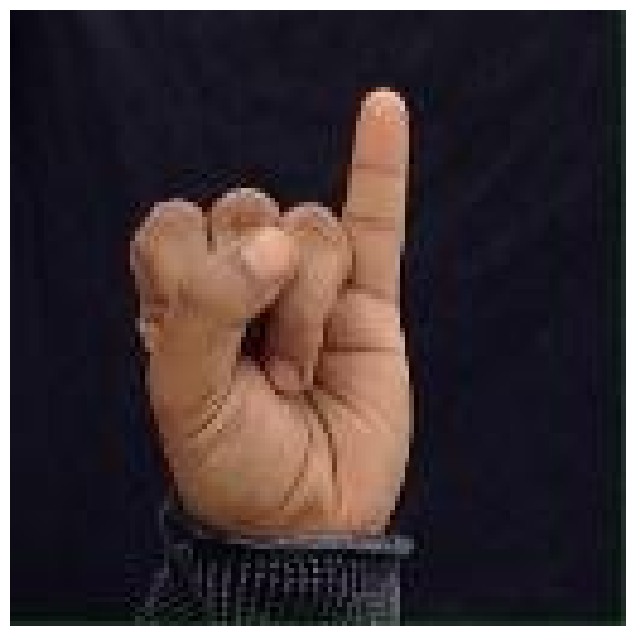

'Class: 7'

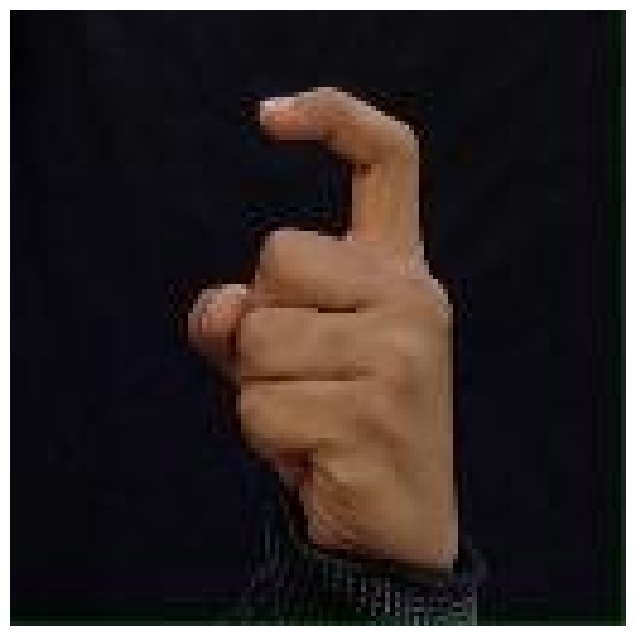

'Class: 8'

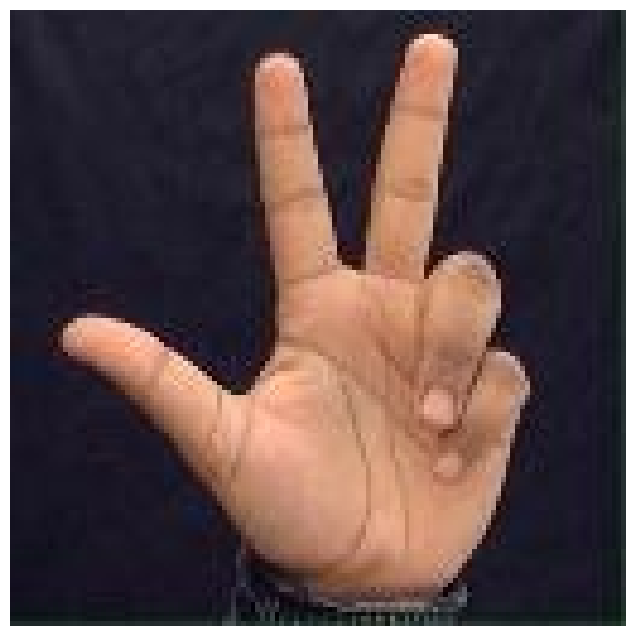

'Class: 9'

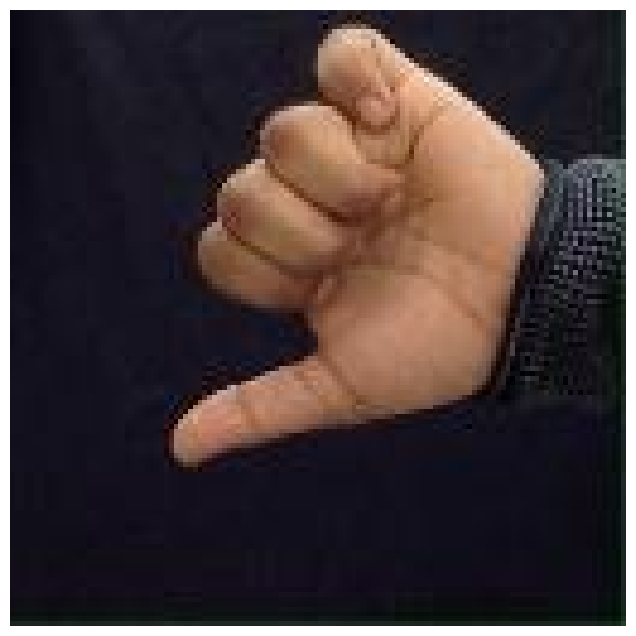

'Class: A'

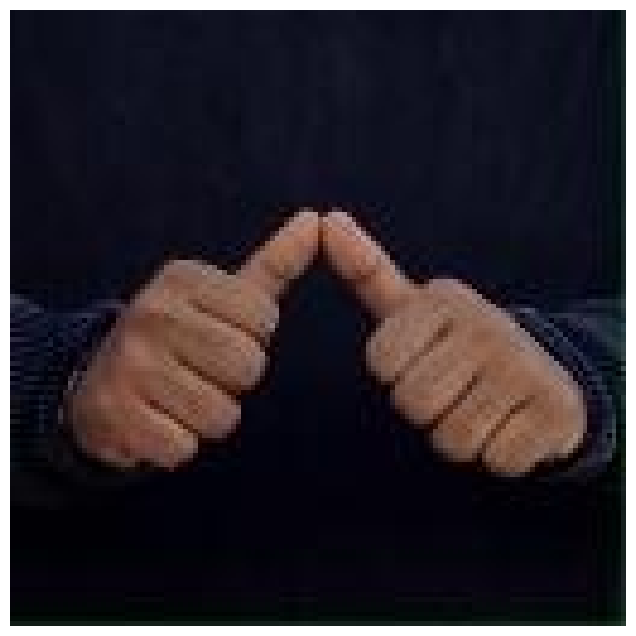

'Class: B'

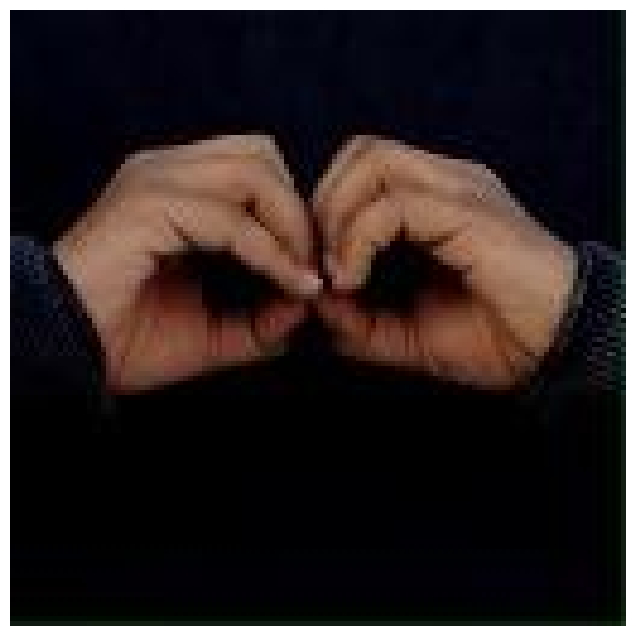

'Class: C'

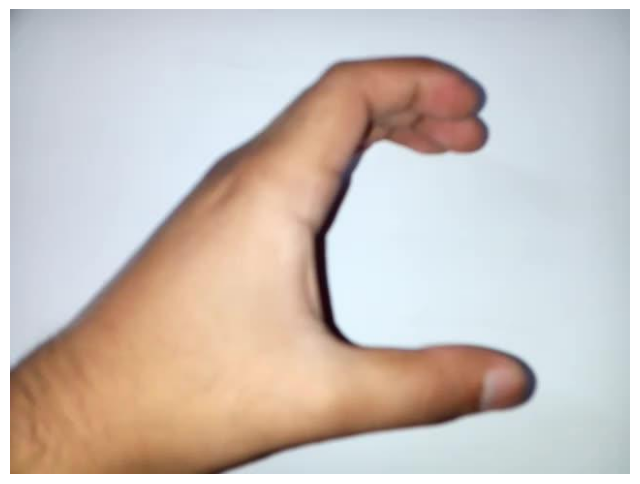

'Class: D'

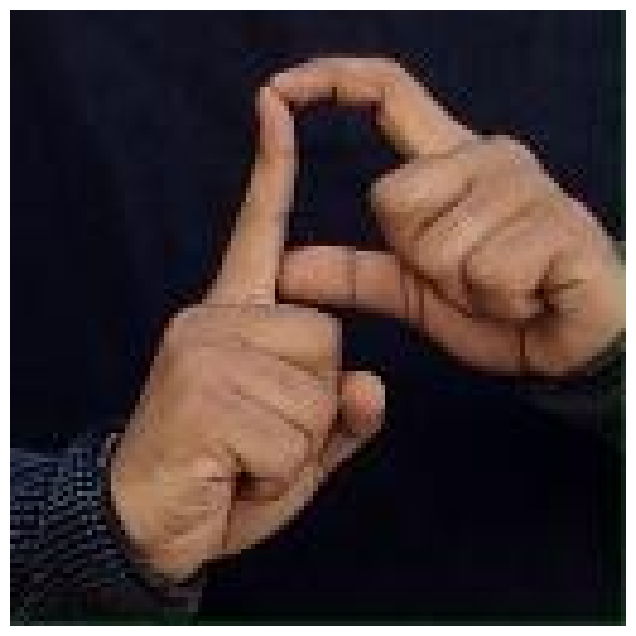

'Class: E'

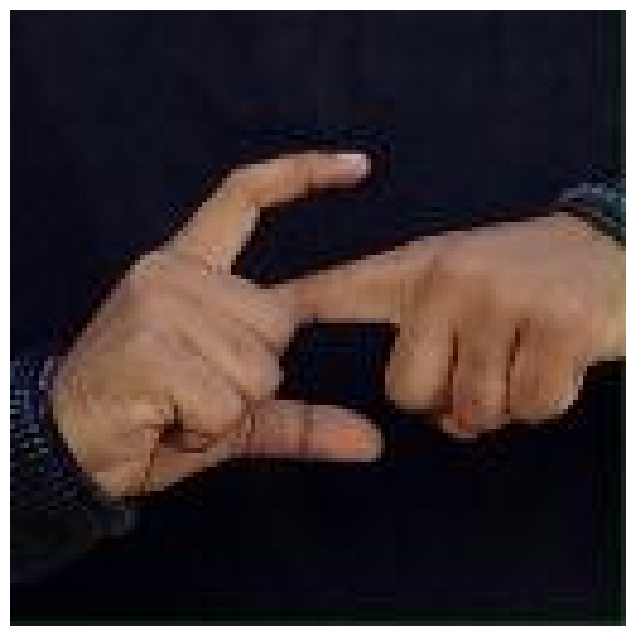

'Class: ExcuseMe'

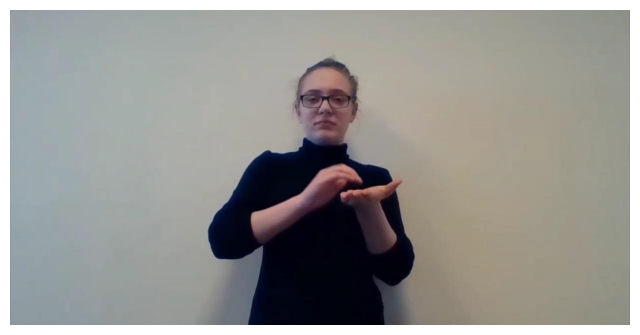

'Class: F'

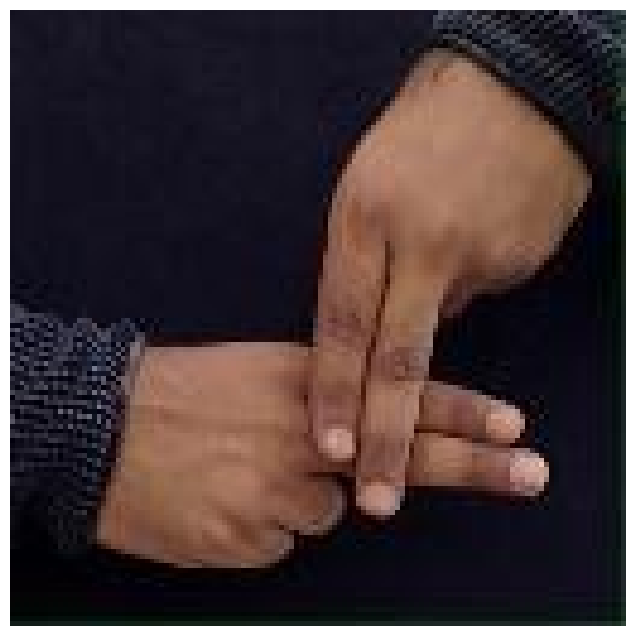

'Class: Food'

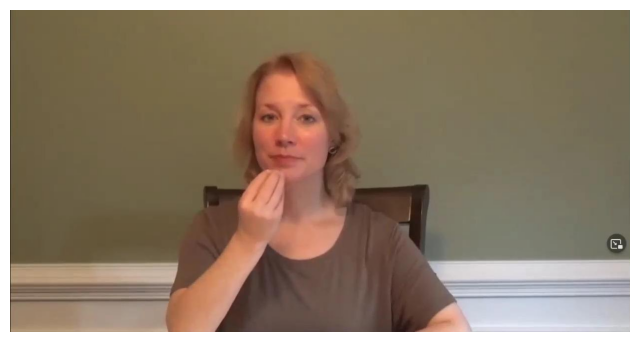

'Class: G'

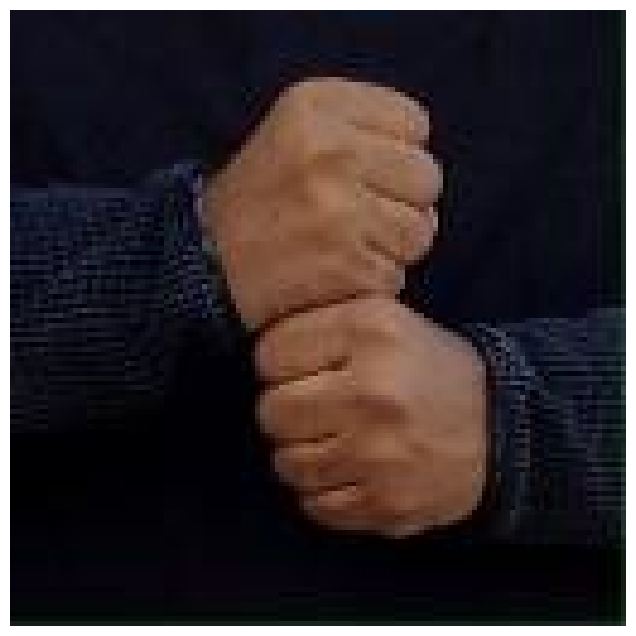

'Class: H'

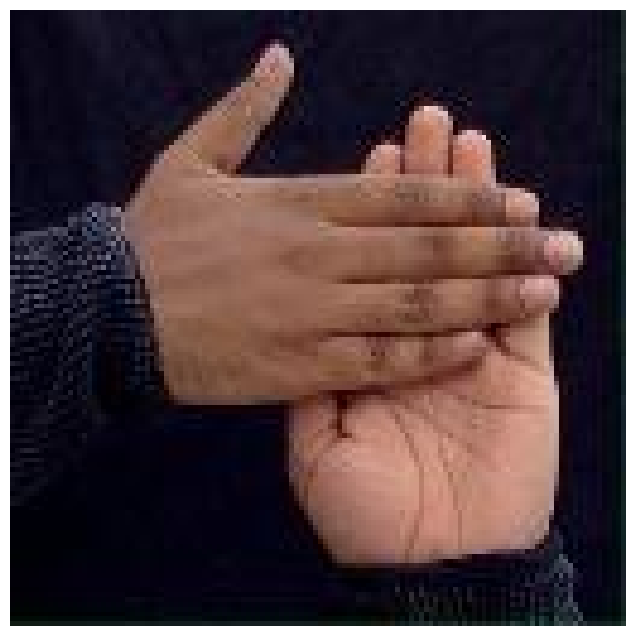

'Class: Hello'

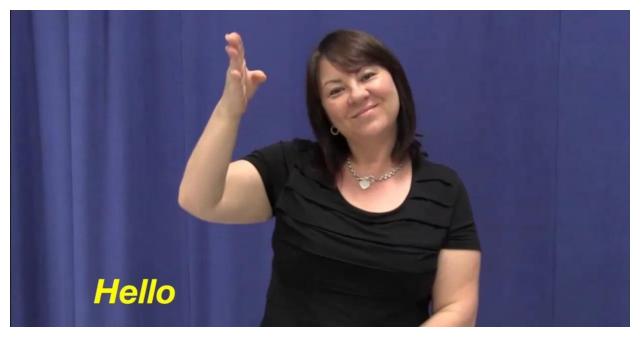

'Class: Help'

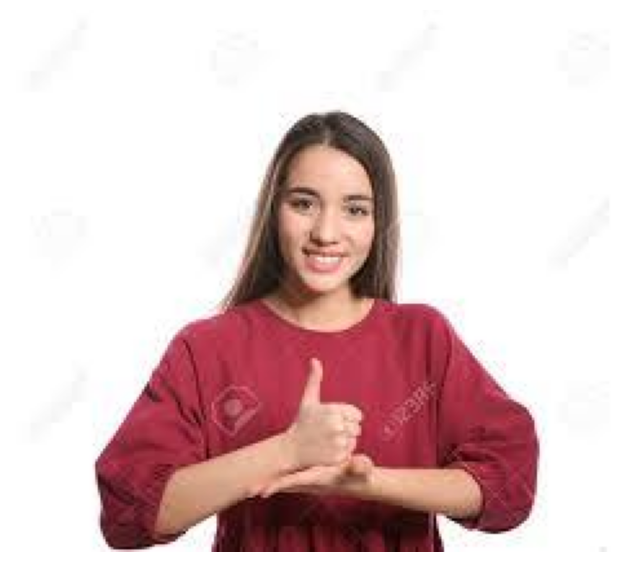

'Class: House'

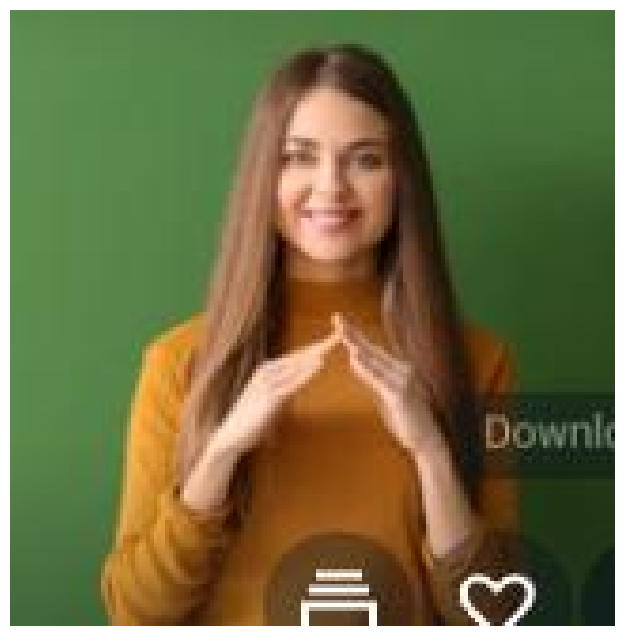

'Class: I'

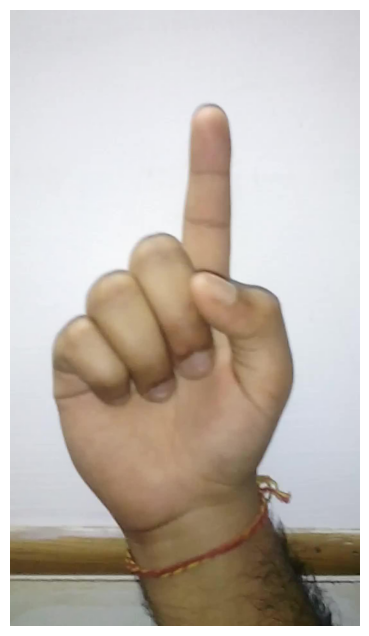

'Class: I Love You'

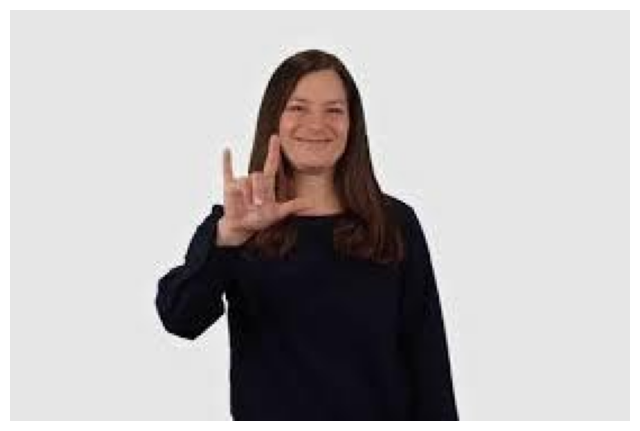

'Class: J'

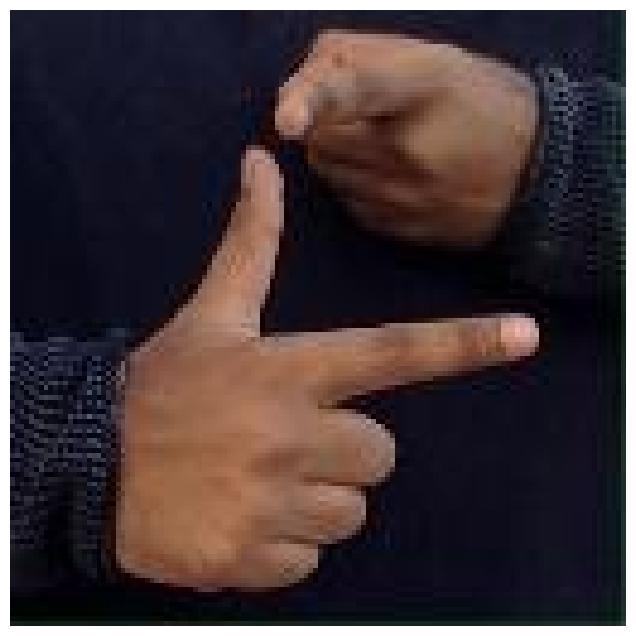

'Class: K'

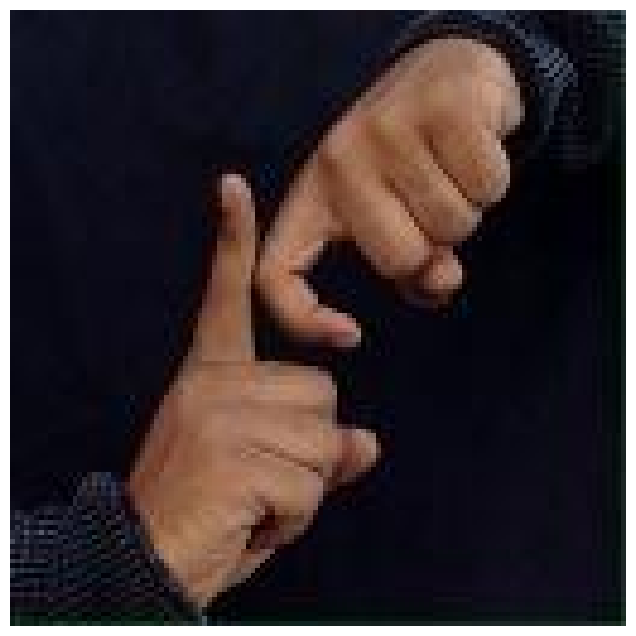

'Class: L'

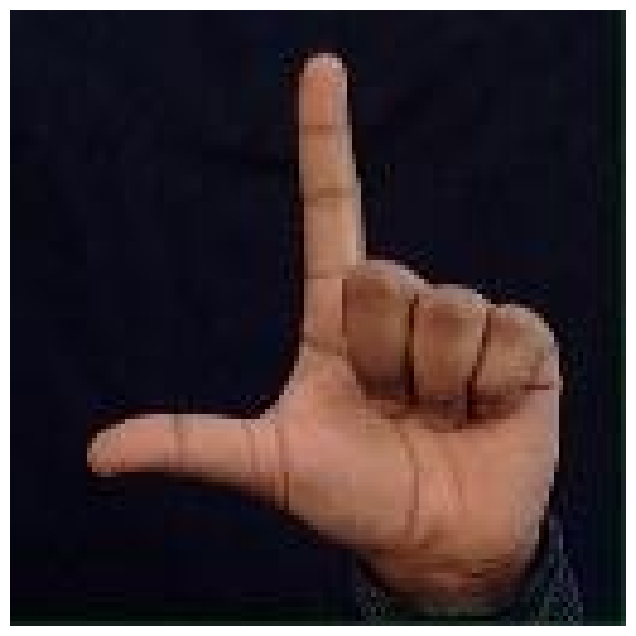

'Class: M'

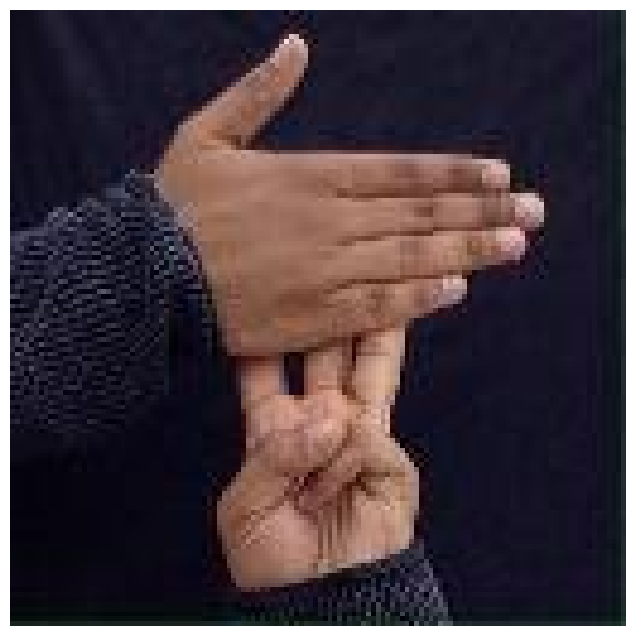

'Class: N'

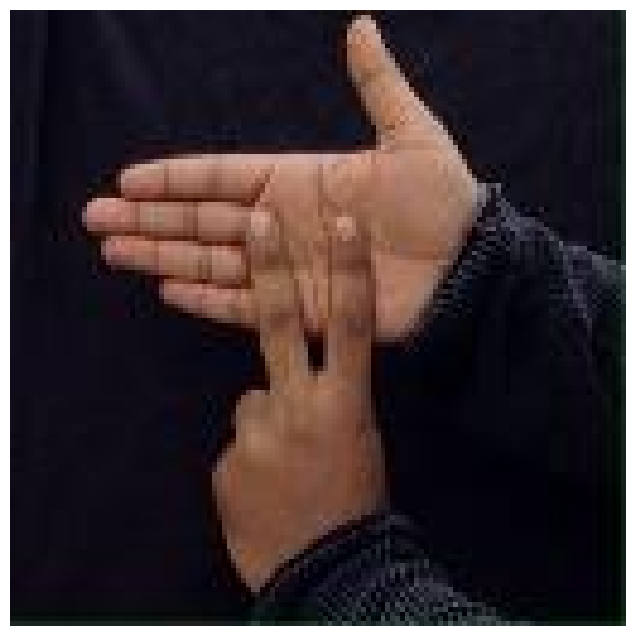

'Class: No'

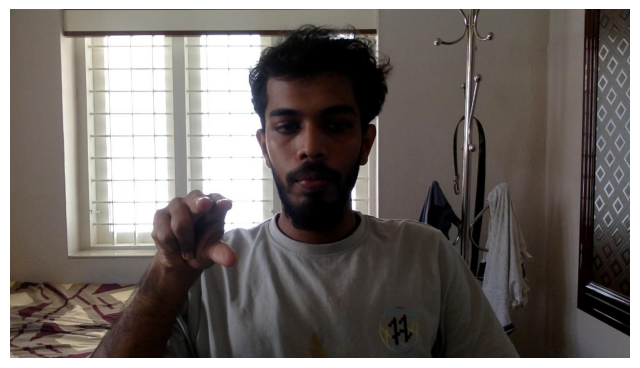

'Class: O'

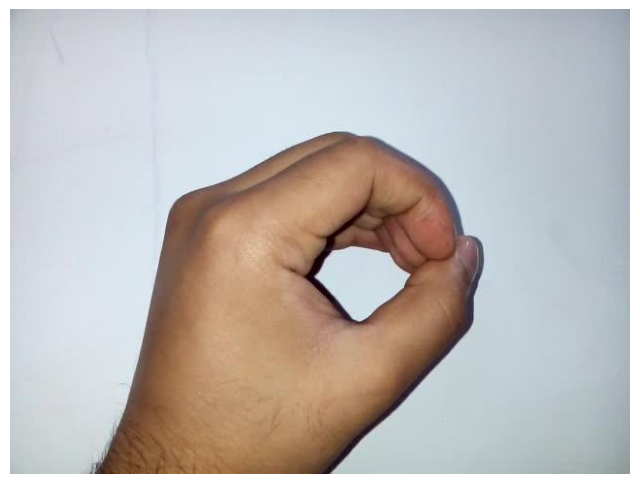

'Class: P'

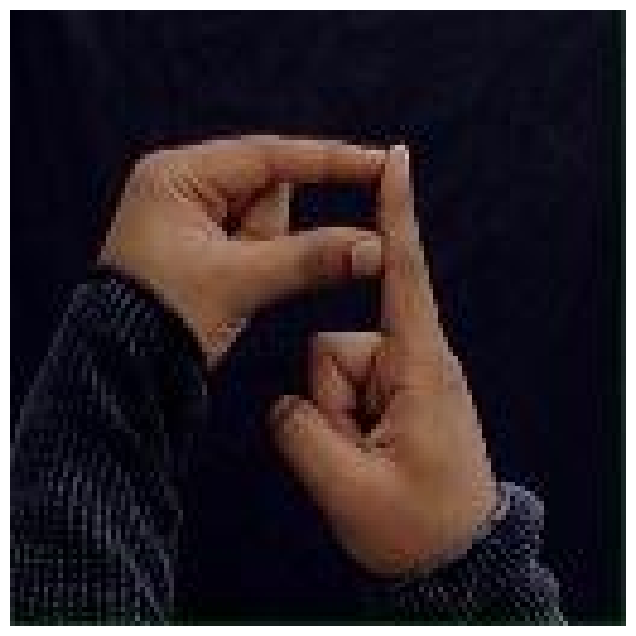

'Class: Please'

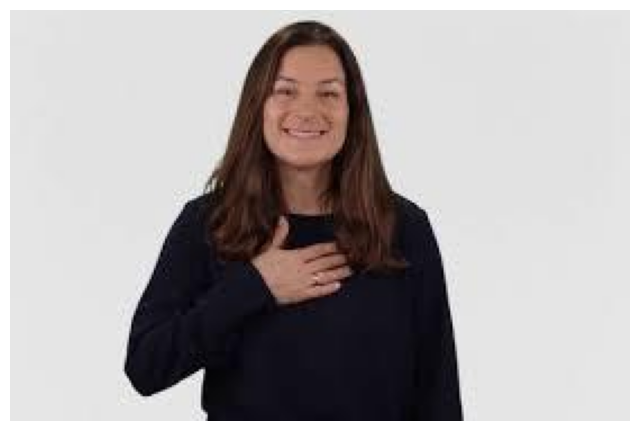

'Class: Q'

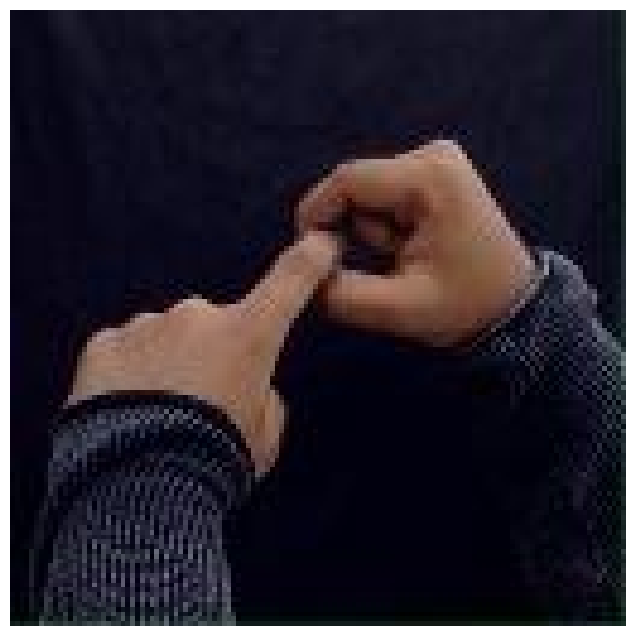

'Class: R'

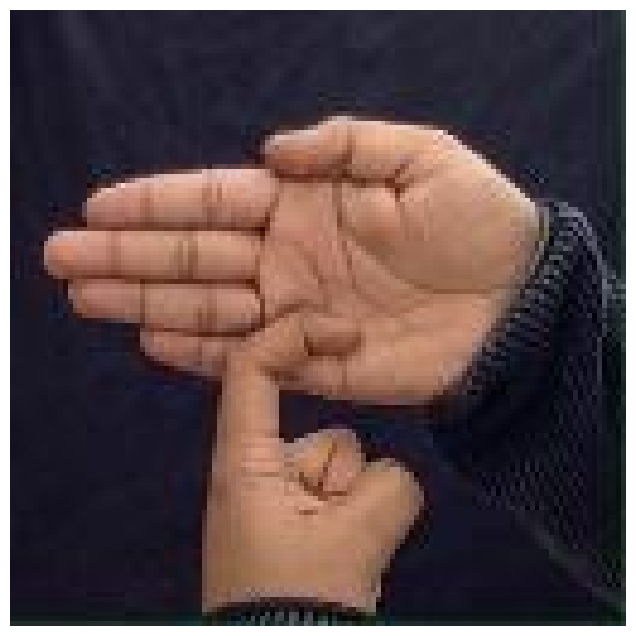

'Class: S'

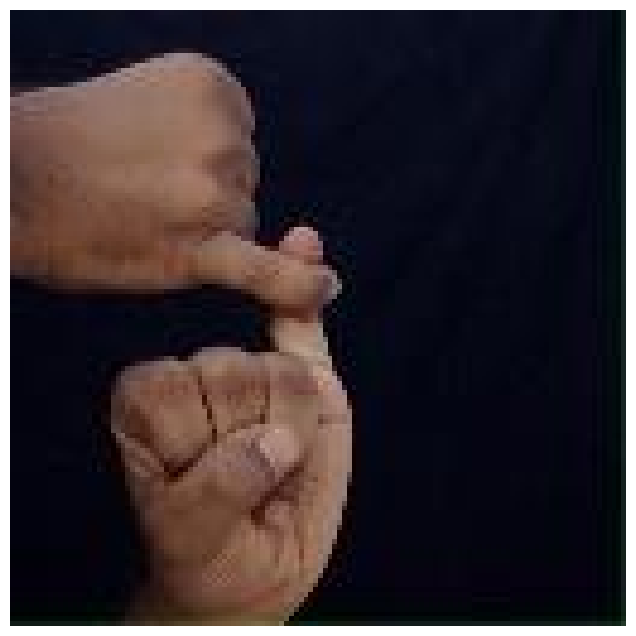

'Class: T'

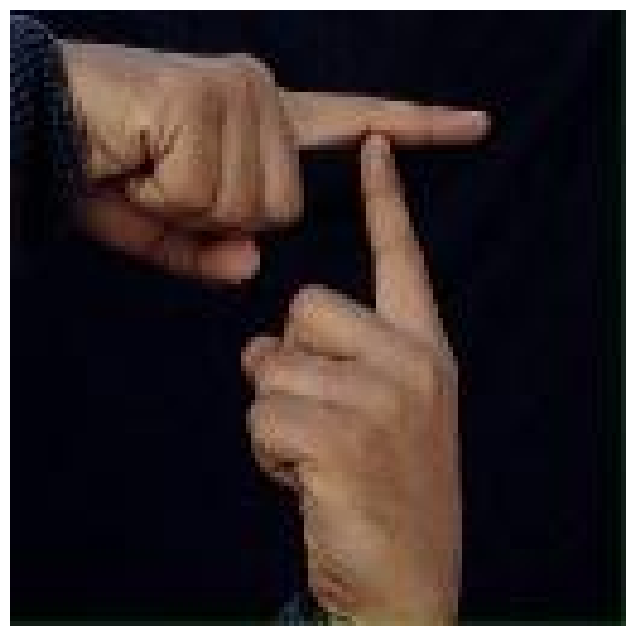

'Class: ThankYou'

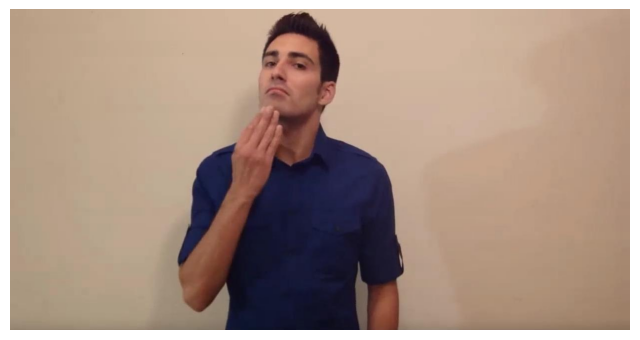

'Class: U'

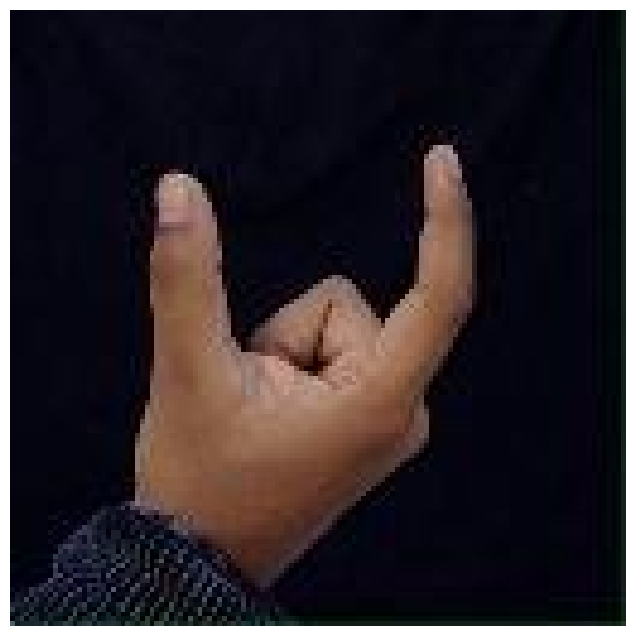

'Class: V'

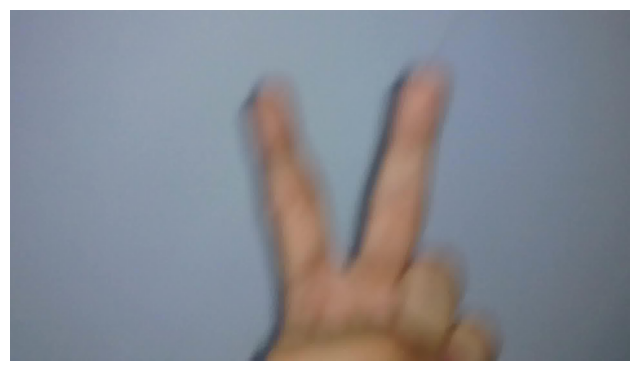

'Class: W'

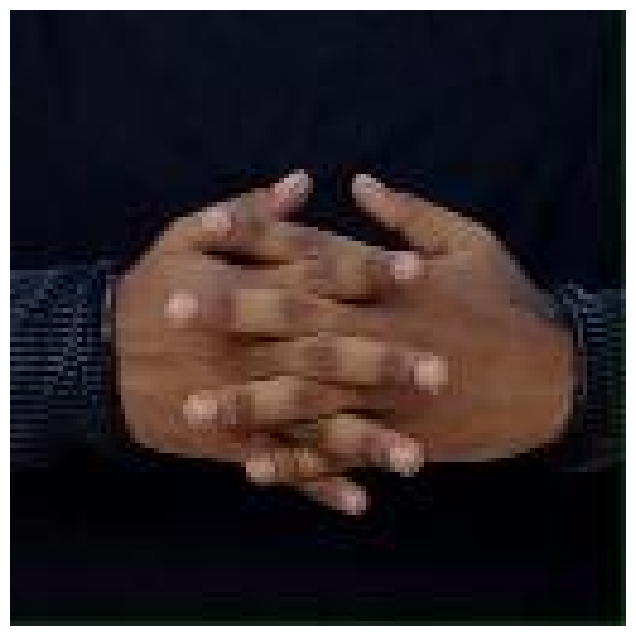

'Class: X'

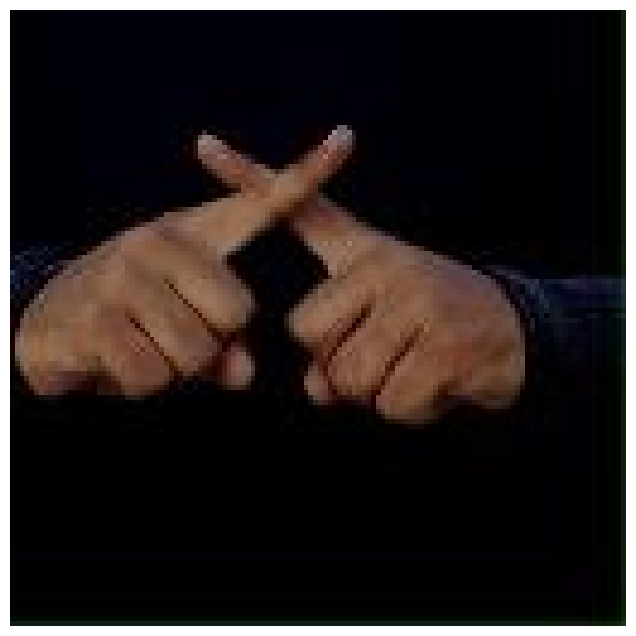

'Class: Y'

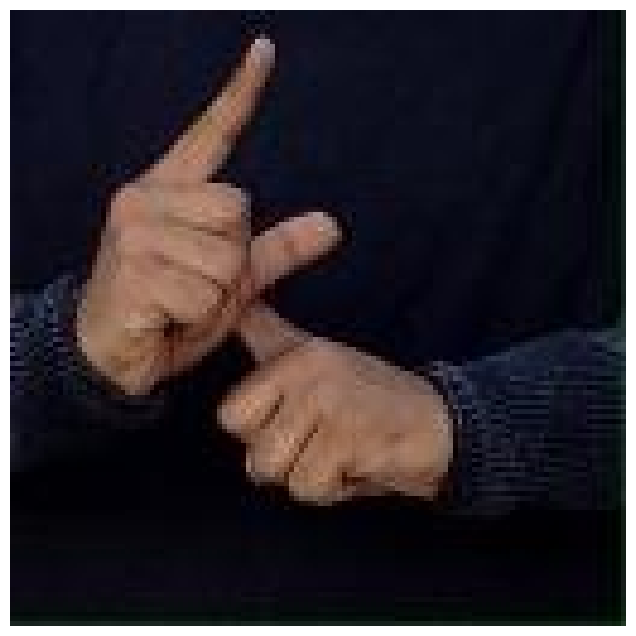

'Class: Yes'

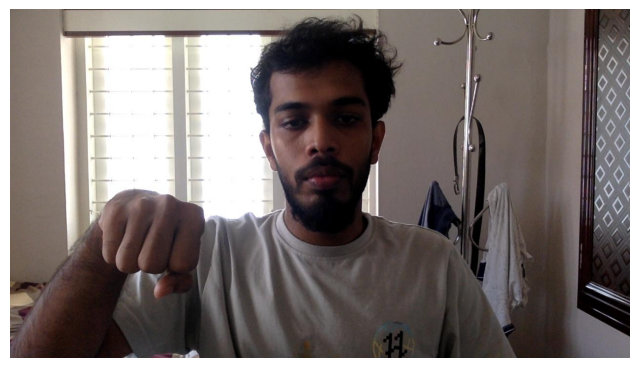

'Class: Z'

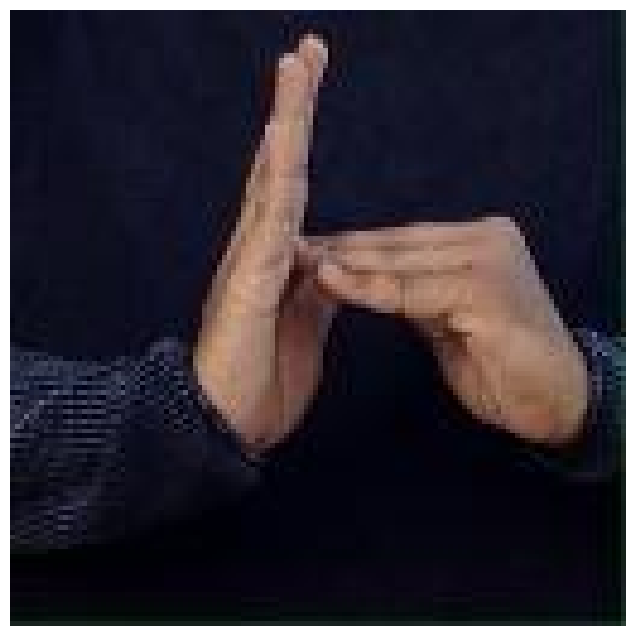

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

def display_single_examples(base_dir):
    """Display one example per sign class individually"""
    
    sign_classes = [
        "1", "2", "3", "4", "5", "6", "7", "8", "9", "A", "B", "C", "D", "E", 
        "ExcuseMe", "F", "Food", "G", "H", "Hello", "Help", "House", "I", 
        "I Love You", "J", "K", "L", "M", "N", "No", "O", "P", "Please", "Q", 
        "R", "S", "T", "ThankYou", "U", "V", "W", "X", "Y", "Yes", "Z"
    ]
    
    # Process all splits to find one example per class
    for class_id in range(len(sign_classes)):
        found = False
        for split in ['train', 'test', 'valid']:
            if found:
                break
                
            image_dir = os.path.join(base_dir, split, 'images')
            label_dir = os.path.join(base_dir, split, 'labels')
            
            if not (os.path.exists(image_dir) and os.path.exists(label_dir)):
                continue
                
            # Find first image of this class
            for label_file in os.listdir(label_dir):
                with open(os.path.join(label_dir, label_file), 'r') as f:
                    file_class_id = int(f.readline().strip().split()[0])
                    
                if file_class_id == class_id:
                    image_name = label_file.replace('.txt', '.jpg')
                    image_path = os.path.join(image_dir, image_name)
                    
                    # Read and display image
                    image = cv2.imread(image_path)
                    if image is not None:
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        
                        display(f"Class: {sign_classes[class_id]}")
                        plt.figure(figsize=(8, 8))
                        plt.imshow(image)
                        plt.axis('off')
                        plt.show()
                        found = True
                        break

if __name__ == "__main__":
    display_single_examples(".")  # Pass your dataset directory